Saving virtuoso.csv to virtuoso (5).csv


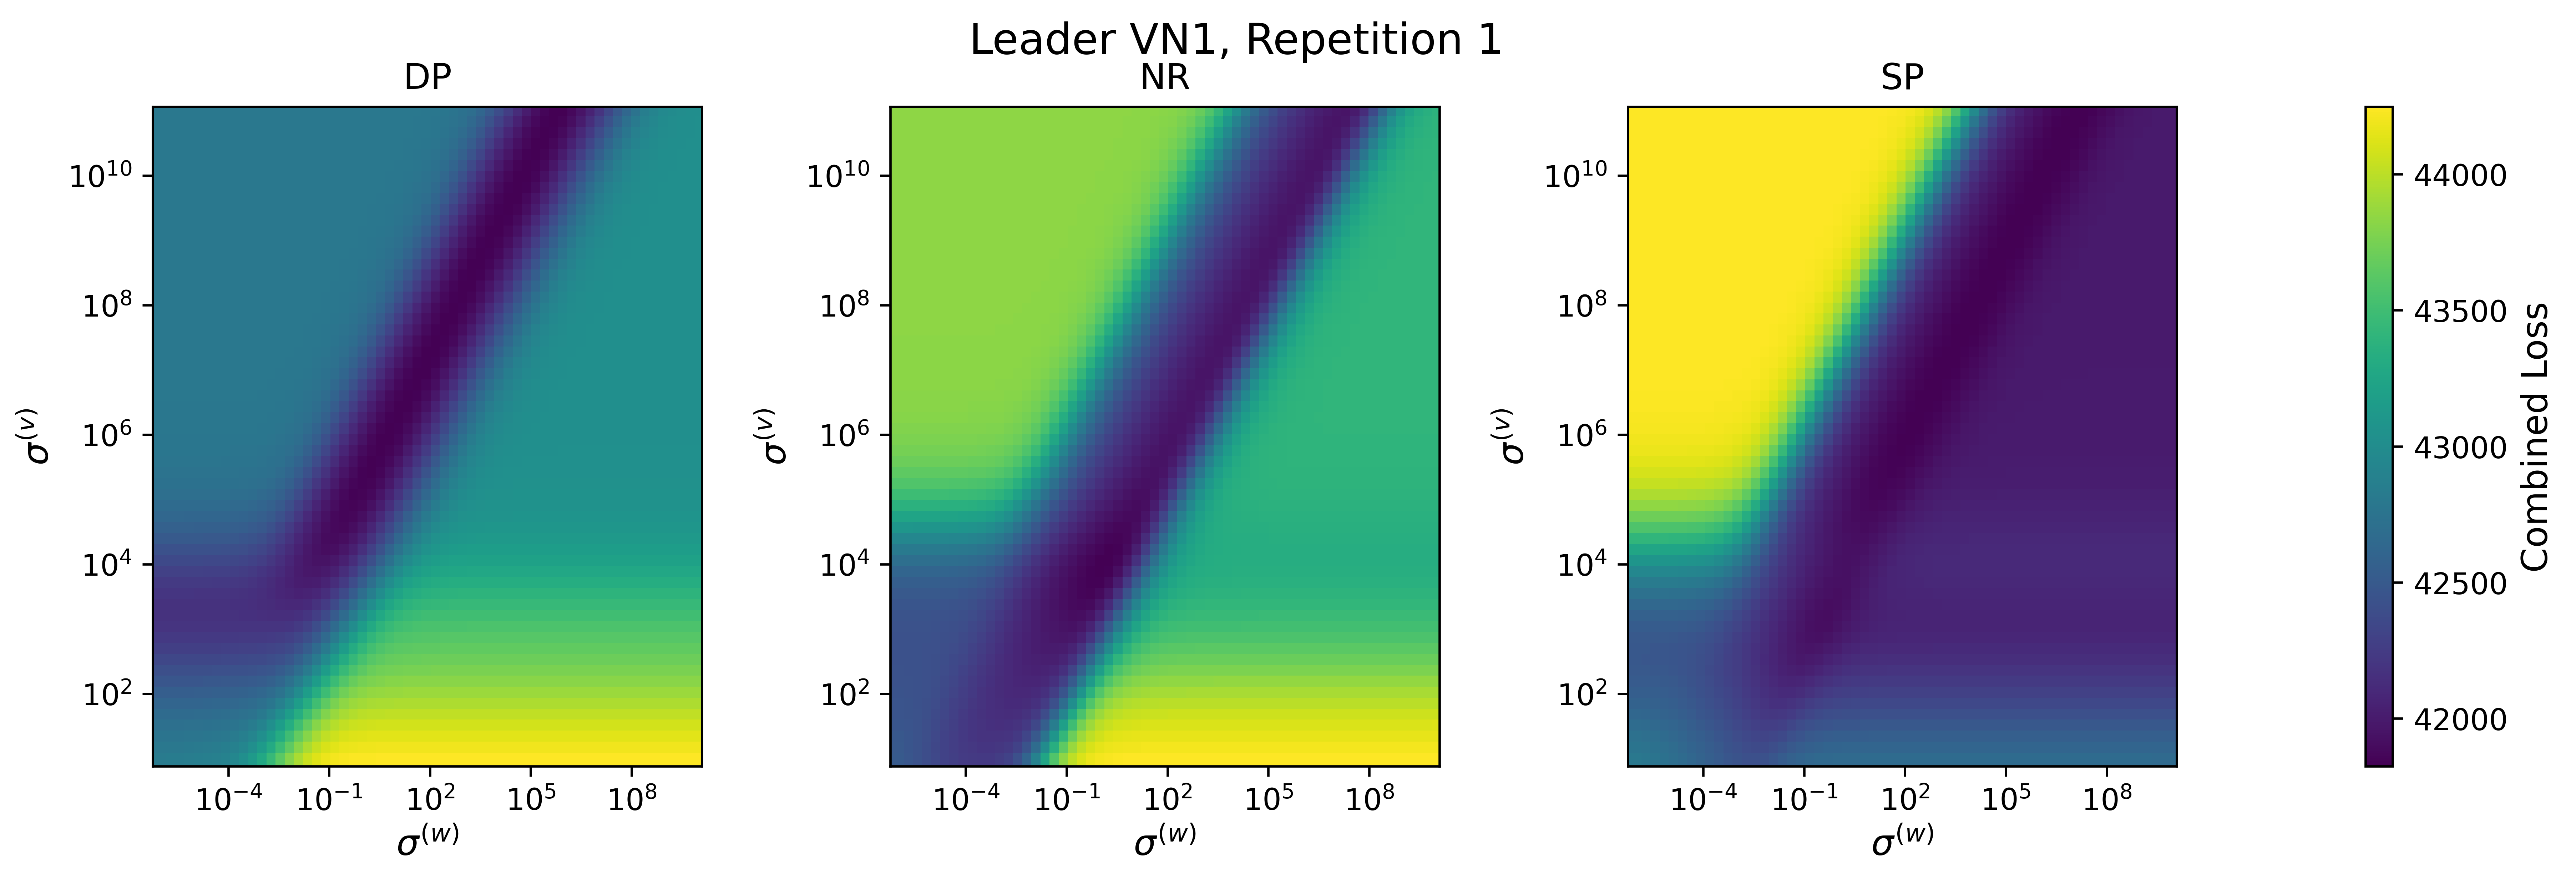

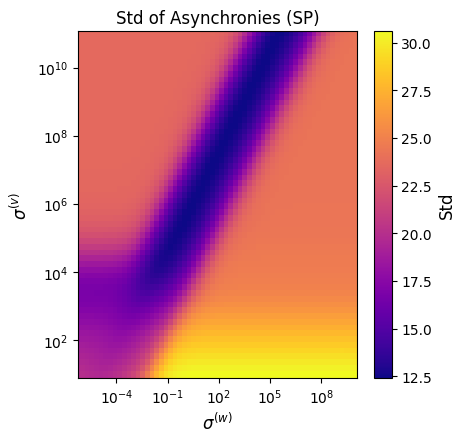

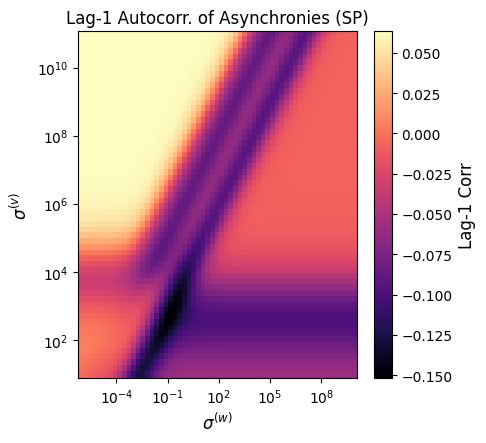

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2159692020.py:386: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from google.colab import files
import io
from scipy.linalg import block_diag
from scipy.optimize import minimize

# PLOS guideline safe
mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "font.size": 12,
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# upload file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# read file
def process_ensemble_data(leader, rep, w, filepath=filename):
    virtuoso = pd.read_csv(filepath)

    N = 46
    K = 4

    ioi_cols = ['ioi' + str(k) for k in range(N)]
    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(k1) + str(k2) for k1 in range(1, K + 1) for k2 in range(1, K + 1) if k1 != k2]

    r_dp = virtuoso[(virtuoso['condition'] == 'DP') & (virtuoso['leader'] == leader) & (virtuoso['repetition'] == rep)][ioi_cols].values
    r_nr = virtuoso[(virtuoso['condition'] == 'NR') & (virtuoso['leader'] == leader) & (virtuoso['repetition'] == rep)][ioi_cols].values
    r_sp = virtuoso[(virtuoso['condition'] == 'SP') & (virtuoso['leader'] == leader) & (virtuoso['repetition'] == rep)][ioi_cols].values

    aux = np.empty((4, 2))
    aux.fill(np.nan)
    r_dp = dict(zip(players, np.hstack((aux, r_dp))))
    r_nr = dict(zip(players, np.hstack((aux, r_nr))))
    r_sp = dict(zip(players, np.hstack((aux, r_sp))))

    t_dp = {player: np.hstack((np.nan, 0, r_dp[player][2:].cumsum())) for player in players}
    t_nr = {player: np.hstack((np.nan, 0, r_nr[player][2:].cumsum())) for player in players}
    t_sp = {player: np.hstack((np.nan, 0, r_sp[player][2:].cumsum())) for player in players}

    A_dp = {pair: t_dp[pair[0]] - t_dp[pair[1]] for pair in pairs}
    A_nr = {pair: t_nr[pair[0]] - t_nr[pair[1]] for pair in pairs}
    A_sp = {pair: t_sp[pair[0]] - t_sp[pair[1]] for pair in pairs}

    s_dp_win = {player: 2*[np.nan] for player in players}
    s_nr_win = {player: 2*[np.nan] for player in players}
    s_sp_win = {player: 2*[np.nan] for player in players}

    for n in range(2, N + 2):
        for player in players:
            if n <= w:
                s_dp_win[player].append(r_dp[player][n] - np.mean(r_dp[player][2:n+1]))
                s_nr_win[player].append(r_nr[player][n] - np.mean(r_nr[player][2:n+1]))
                s_sp_win[player].append(r_sp[player][n] - np.mean(r_sp[player][2:n+1]))
            else:
                s_dp_win[player].append(r_dp[player][n] - np.mean(r_dp[player][n-w+1:n+1]))
                s_nr_win[player].append(r_nr[player][n] - np.mean(r_nr[player][n-w+1:n+1]))
                s_sp_win[player].append(r_sp[player][n] - np.mean(r_sp[player][n-w+1:n+1]))

    s_dp_win = {player: np.array(vals) for player, vals in s_dp_win.items()}
    s_nr_win = {player: np.array(vals) for player, vals in s_nr_win.items()}
    s_sp_win = {player: np.array(vals) for player, vals in s_sp_win.items()}

    return r_dp, r_nr, r_sp, s_dp_win, s_nr_win, s_sp_win, A_dp, A_nr, A_sp, t_dp, t_nr, t_sp

############################
## ENSEMBLE KALMAN FILTER ##
############################

def KF_ensemble(s, A, Sigma_v_init, Sigma_w, alpha_KF_init, Sigma_alpha_init, w):
    K = len(s) # Number of players

    players = [str(k) for k in range(1, K + 1)]
    pairs = [str(k1) + str(k2) for k1 in range(1, K + 1) for k2 in range(1, K + 1) if k1 != k2]

    N = s['1'].shape[0] - 1

    # Initialise predictions for alpha (with NaN for n = 0 and n = 1)
    alpha_KF_predict = 2*[np.nan]
    Sigma_alpha_KF_predict = 2*[np.nan]

    # Initialise predictions for s (with NaN for n = 0 and n = 1)
    s_KF_predict = 2*[K*[np.nan]]
    Sigma_s_KF_predict = 2*[np.nan]

    # Initialise updates for alpha (with n = 0 and n = 1)
    gain_KF = 2*[np.nan]
    alpha_KF_update = [K*(K - 1)*[np.nan], alpha_KF_init]
    Sigma_alpha_KF_update = [np.nan, Sigma_alpha_init]

    # Initialise dynamic estimation of sigma_v [TESTING] (with n = 0 and n = 1)
    Sigma_v = [np.nan, Sigma_v_init]

    # Initialise matrix F
    F = [np.nan, np.nan]

    log_l = 0.0 # RD

    for n in range(2, N + 1):
        # Build matrix F_n
        F_list = []
        for player1 in players:
            A_i = []
            for player2 in players:
                if player2 != player1:
                    A_i.append(-A[player1 + player2][n - 1])
            F_list.append(A_i)
        F.append(block_diag(*F_list))

        # Make vector with s at time n
        s_n_vec = np.array([s[player][n] for player in players])

        # Predict alpha
        alpha_KF_predict.append(alpha_KF_update[n - 1])
        Sigma_alpha_KF_predict.append(Sigma_alpha_KF_update[n - 1] + Sigma_w)

        # Predict s
        s_KF_predict.append(F[n] @ alpha_KF_predict[n])
        Sigma_s_KF_predict.append(F[n] @ Sigma_alpha_KF_predict[n] @ F[n].T + Sigma_v[n - 1])

        # RD: Innovation
        innov = s_n_vec - (F[n] @ alpha_KF_predict[n])
        S_innov = np.linalg.inv(F[n] @ Sigma_alpha_KF_predict[n] @ F[n].T + Sigma_v[n - 1])
        # RD: Log-likelihood contribution
        log_l += -0.5 * (np.log(np.linalg.det(2*np.pi*(F[n] @ Sigma_alpha_KF_predict[n] @ F[n].T + Sigma_v[n - 1]))) + innov.T @ S_innov @ innov)

        # Update alpha
        gain_KF.append(Sigma_alpha_KF_predict[n] @ F[n].T @ np.linalg.inv(Sigma_s_KF_predict[n]))
        alpha_KF_update.append(alpha_KF_predict[n] + gain_KF[n] @ (s_n_vec - s_KF_predict[n]))
        Sigma_alpha_KF_update.append(Sigma_alpha_KF_predict[n] - gain_KF[n] @ F[n] @ Sigma_alpha_KF_predict[n])

        Sigma_v.append(Sigma_v_init)

    # Prepare outputs (the most important ones)
    s_KF_predict = dict(zip(players, np.array(s_KF_predict).T))
    alpha_KF_update = dict(zip(pairs, np.array(alpha_KF_update).T))

    return s_KF_predict, alpha_KF_update, log_l # RD: got rid of unneeded outputs

###############################################
## RECONSTRUCT r FROM s_estimated (ensemble) ##
###############################################

def r_from_s_ensemble(s_est, r, w = 5):
    N = r['1'].shape[0] - 1

    players = r.keys()

    r_est = {}

    for player in players:
        r_est[player] = 2*[np.nan] # n = 0 and n = 1

    for n in range(2, w + 1):
        for player in players:
            r_est[player].append(np.nan)

    for n in range(w + 1, N + 1):
        for player in players:
            r_est[player].append(s_est[player][n] + np.mean(r[player][(n - w - 1 + 2):(n - 1 + 2)]))

    for player in players:
        r_est[player] = np.array(r_est[player])

    return r_est

# combined loss: weighted (sum of mse s pred vs s true) AND (mse of pairwise asynchronies)
weight = 1.0
def combined_loss(r_dict, s_win, A, w, KF_func, params, weight=weight):
    sigma_w = params['sigma_w']
    sigma_v = params['sigma_v']
    sigma_alpha = params.get('sigma_alpha', 0.3)
    alpha_init = params.get('alpha_init', 0.25)

    K = len(s_win)
    players = [str(k) for k in range(1, K + 1)]

    Sigma_v = np.diag([sigma_v] * K)
    Sigma_alpha = np.diag([sigma_alpha] * (K * (K - 1)))

    s_hat, _, _ = KF_func(
        s=s_win,
        A=A,
        Sigma_v_init=Sigma_v,
        Sigma_w=sigma_w,
        alpha_KF_init=[alpha_init] * (K * (K - 1)),
        Sigma_alpha_init=Sigma_alpha,
        w=w
    )

   # mse for s timeseries
    mse_s = []
    for p in players:
        pred = np.roll(s_hat[p], 1)
        mask = ~np.isnan(pred) & ~np.isnan(r_dict[p])
        mse = np.mean((pred[mask] - r_dict[p][mask]) ** 2)
        mse_s.append(mse)

    # mse for asynchronies (pairwise)
    r_est = r_from_s_ensemble(s_hat, r_dict, w)
    pairs = [str(i) + str(j) for i in players for j in players if i != j]

    mse_async = []
    for pair in pairs:
        true_A = A[pair]
        pred_A = r_est[pair[0]] - r_est[pair[1]]
        mask = ~np.isnan(true_A) & ~np.isnan(pred_A)
        mse = np.mean((pred_A[mask] - true_A[mask]) ** 2)
        mse_async.append(mse)

    # weighted sum of each mse
    mse_per_player = [s + weight * a for s, a in zip(mse_s, mse_async[:len(players)])]

    # return dict for consistency with likelihood_loss
    return dict(zip(players, mse_per_player))

def lag1_ac(x):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    return np.corrcoef(x[:-1], x[1:])[0, 1] if len(x) > 1 else np.nan

def compute_std_and_lag1(A_true, r_est):
    # compute mean std and lag-1 autocorr of async errors
    stds, lags = [], []
    for pair in A_true:
        pred = r_est[pair[0]] - r_est[pair[1]]
        true = A_true[pair]
        mask = ~np.isnan(pred) & ~np.isnan(true)
        if mask.sum() > 1:
            # resid = true[mask] - pred[mask]
            resid = pred[mask]
            stds.append(np.std(resid))
            lags.append(lag1_ac(resid))
    return np.mean(stds), np.mean(lags)

def run_model(params, r_data, s_data, A, w):
    # run KF with params dict, return r_est only
    s_hat, _, _ = KF_ensemble(
        s=s_data,
        A=A,
        Sigma_v_init=np.diag([params['sigma_v']] * len(s_data)),
        Sigma_w=params['sigma_w'],
        alpha_KF_init=[params['alpha_init']] * (len(s_data)*(len(s_data)-1)),
        Sigma_alpha_init=np.diag([params['sigma_alpha']] * (len(s_data)*(len(s_data)-1))),
        w=w
    )
    r_est = r_from_s_ensemble(s_hat, r_data, w)
    return r_est

# heatmap plots only
leaders = ['VN1', 'VN2']
reps = [1, 2, 5, 8, 11, 12]
conds = ['DP', 'NR', 'SP']
rep = 1
w = 5
weight = 1.0

# param ranges
sigma_v_values = np.logspace(1, 11, 60)
sigma_w_values = np.logspace(-6, 10, 60)

for leader in leaders:
    for rep in reps:

        r_dp, r_nr, r_sp, s_dp, s_nr, s_sp, A_dp, A_nr, A_sp, _, _, _ = process_ensemble_data(
            leader=leader,
            rep=rep,
            w=w
        )

        conditions_data = {
            'DP': {'r_data': r_dp, 's_data': s_dp, 'A': A_dp},
            'NR': {'r_data': r_nr, 's_data': s_nr, 'A': A_nr},
            'SP': {'r_data': r_sp, 's_data': s_sp, 'A': A_sp}
        }

        # fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=600)
        fig = plt.figure(figsize=(13.5, 4), dpi=600)

        gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05], wspace=0.45)

        axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
        cax = fig.add_subplot(gs[0, 3])

        for cond in conds:
            r_data = conditions_data[cond]['r_data']
            s_data = conditions_data[cond]['s_data']
            A = conditions_data[cond]['A']

        for ax, cond in zip(axes, conds):
            r_data = conditions_data[cond]['r_data']
            s_data = conditions_data[cond]['s_data']
            A = conditions_data[cond]['A']

            # combined loss heatmap
            loss_grid = np.full((len(sigma_v_values), len(sigma_w_values)), np.nan)

            for i, sigma_v in enumerate(sigma_v_values):
                for j, sigma_w in enumerate(sigma_w_values):
                    params_test = {
                        'sigma_v': sigma_v,
                        'sigma_w': sigma_w,
                        'sigma_alpha': 0.3,  # fixed
                        'alpha_init': 0.25   # fixed
                    }
                    try:
                        loss_dict = combined_loss(r_data, s_data, A, w, KF_ensemble, params_test, weight=weight)
                        loss_grid[i, j] = np.nanmean(list(loss_dict.values()))
                    except np.linalg.LinAlgError:
                        pass  # unstable combos left as nan

            # plot combined loss heatmap
            S_W, S_V = np.meshgrid(sigma_w_values, sigma_v_values)
            h = ax.pcolormesh(S_W, S_V, loss_grid, shading='auto', cmap='viridis', rasterized=True)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel(r"$\sigma^{(w)}$")
            ax.set_ylabel(r"$\sigma^{(v)}$")
            ax.set_title(cond)

        fig.suptitle(f'Leader {leader}, Repetition {rep}')
        cbar = fig.colorbar(h, cax=cax)
        cbar.set_label('Combined Loss')

        # show all heatmaps for VN1 rep 1
        if leader == 'VN1' and rep == 1:
            plt.show()

            # std & lag-1 autocorr. heatmaps
            std_map = np.zeros_like(loss_grid)
            lag_map = np.zeros_like(loss_grid)

            for i, sigma_v in enumerate(sigma_v_values):
                for j, sigma_w in enumerate(sigma_w_values):
                    params_test = {
                        'sigma_v': sigma_v,
                        'sigma_w': sigma_w,
                        'sigma_alpha': 0.3,
                        'alpha_init': 0.25
                    }
                    try:
                        r_est = run_model(params_test, r_data, s_data, A, w)
                        std_val, lag_val = compute_std_and_lag1(A, r_est)
                        std_map[i,j] = std_val
                        lag_map[i,j] = lag_val
                    except np.linalg.LinAlgError:
                        std_map[i,j] = np.nan
                        lag_map[i,j] = np.nan

            # plot std of asynchronies
            fig, ax = plt.subplots(figsize=(4.5, 4.5))
            im1 = ax.pcolormesh(S_W, S_V, std_map, shading='auto', cmap='plasma')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel(r"$\sigma^{(w)}$")
            ax.set_ylabel(r"$\sigma^{(v)}$")
            ax.set_title(f'Std of Asynchronies ({cond})')
            plt.colorbar(im1, ax=ax, label='Std')
            plt.show()

            # plot lag-1 autocorrelation of asynchronies
            fig, ax = plt.subplots(figsize=(4.5, 4.5))
            im2 = ax.pcolormesh(S_W, S_V, lag_map, shading='auto', cmap='magma')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel(r"$\sigma^{(w)}$")
            ax.set_ylabel(r"$\sigma^{(v)}$")
            ax.set_title(f'Lag-1 Autocorr. of Asynchronies ({cond})')
            plt.colorbar(im2, ax=ax, label='Lag-1 Corr')
            plt.show()
        else:
            pass

        fname = f'{leader}_Rep{rep}'
        plt.tight_layout()
        plt.savefig(fname + '.pdf')
        files.download(fname + '.pdf')
        plt.close()




